In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Copy of data.csv')
df.drop(['oaid_hash', 'banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1'], axis=1, inplace=True)
df.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,0,0,0,1,1
1,2021-09-26 22:54:49.000000,1,1,0,0,1,1,1
2,2021-09-26 23:57:20.000000,2,2,3,0,0,1,1
3,2021-09-27 00:04:30.000000,3,3,0,1,1,1,1
4,2021-09-27 00:06:21.000000,4,4,0,1,0,1,1


Преобразуем date_time отдельно на дни и часы.

In [ ]:
datetime = pd.to_datetime(df['date_time'])
df['date'] = datetime.dt.date
df['hour'] = datetime.dt.hour
df.drop('date_time', axis=1, inplace=True)
df.head()

,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks,date,hour
0,0,0,0,0,0,1,1,2021-09-27,0
1,1,1,0,0,1,1,1,2021-09-26,22
2,2,2,3,0,0,1,1,2021-09-26,23
3,3,3,0,1,1,1,1,2021-09-27,0
4,4,4,0,1,0,1,1,2021-09-27,0


# Анализ

In [ ]:
# Проверим количество уникальных значение
df.nunique()

zone_id            3444
banner_id          1633
campaign_clicks     822
os_id                11
country_id           17
impressions           1
clicks                2
date                  8
hour                 24
dtype: int64

In [ ]:
# impressions имеют только одно значение, можно от него избавиться
df.drop('impressions', axis=1, inplace=True)

zone_id


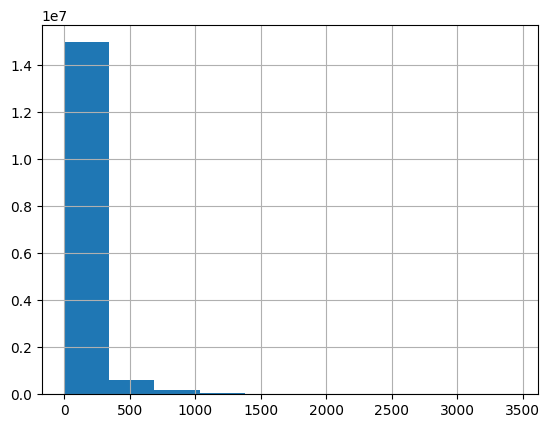


banner_id


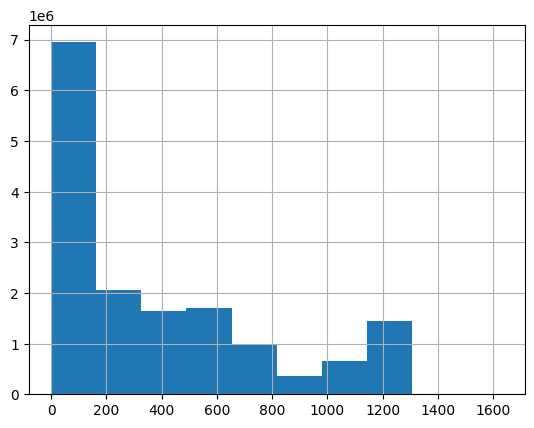


campaign_clicks


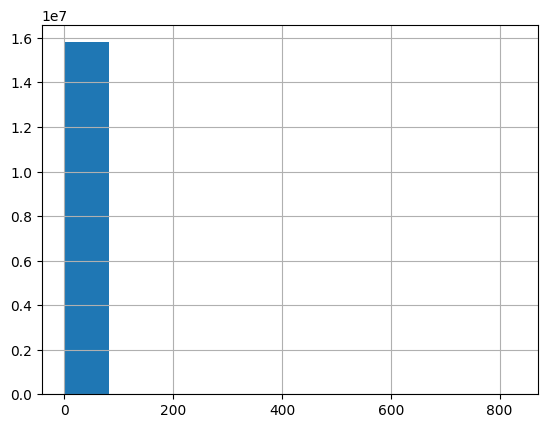


os_id


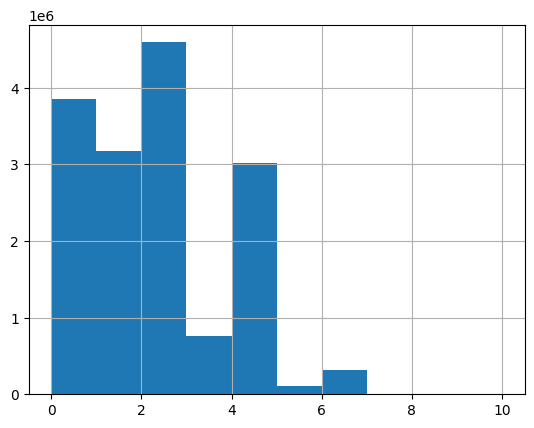


country_id


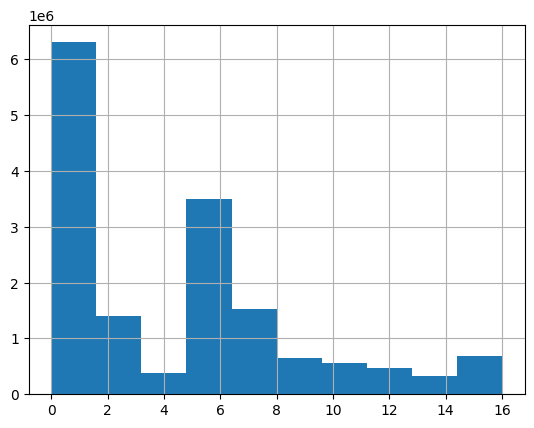


clicks


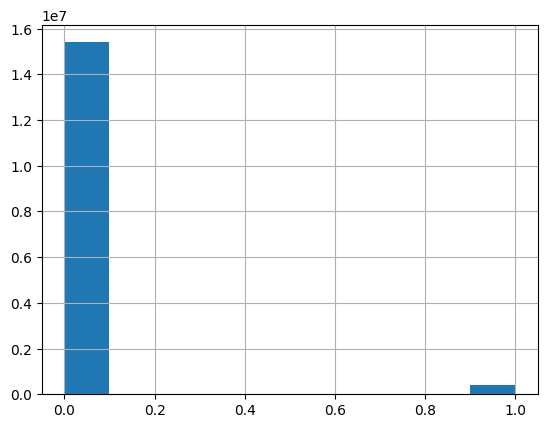


date


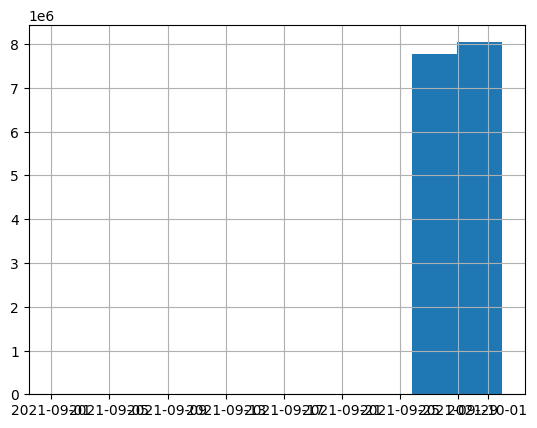


hour


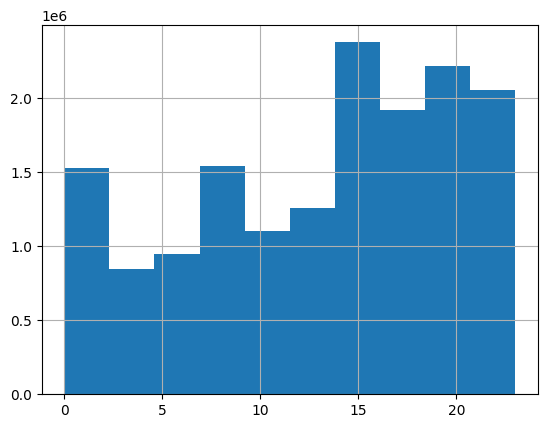

In [ ]:
# Посмотрим на гистограммы
column_names = list(df.columns)
for column in column_names:
  print(f'{column}')
  df[column].hist()
  plt.show()
  print()

zone_id и campain_clicks имеют большое количество значений с небольшим наблюдением, их можно будет объединить.
Часы тоже можно будет использовать как фичу, так как могут влиять на вероятность клика.

# Конструирование фичей

Склеим фичи для zone_id, campain_clicks и os_id

In [ ]:
min_zone_id_value = 10
zone_id_value_counts = df['zone_id'].value_counts()
df['zone_id'] = df['zone_id'].apply(lambda x: -1 if zone_id_value_counts[x] <= 10 else x)

Кажется, что при большом количестве показов, дальнейшие показы уже имеют небольшое значение. Возьмем 10 и более показов за одно значение

In [ ]:
df['campaign_clicks'] = df['campaign_clicks'].apply(lambda x: 10 if x >= 10 else x)

Объединим непопулярные ОС

In [ ]:
df['os_id'].value_counts()

2     4589979
0     3856798
1     3178693
4     3012541
3      759767
6      310346
5      111946
8        1273
7          99
9          25
10          5
Name: os_id, dtype: int64

In [ ]:
os_value_counts = df['os_id'].value_counts()
min_value_os = 10000

df['os_id'] = df['os_id'].apply(lambda x: 7 if os_value_counts[x] < min_value_os else x)

Разделим данные. Последний день на тест, предпоследний на валидацию.

In [ ]:
df['date'].value_counts()

2021-09-26    3102610
2021-09-29    2420588
2021-09-27    2367303
2021-09-28    2307355
2021-10-02    2128978
2021-09-30    1851189
2021-10-01    1643448
2021-09-01          1
Name: date, dtype: int64

Есть выброс, избавимся от него

In [ ]:
df = df[df['date'] != pd.Timestamp('2021-09-01').date()]
df_train = df[df['date'] != pd.Timestamp('2021-10-02').date()]
df_test = df[df['date'] == pd.Timestamp('2021-10-02').date()]
del df
dfs = [df_train, df_test]

In [ ]:
y_train = df_train['clicks'].to_numpy()
y_test = df_test['clicks'].to_numpy()


In [ ]:
df_train

,zone_id,banner_id,campaign_clicks,os_id,country_id,clicks,date,hour
0,0,0,0,0,0,1,2021-09-27,0
1,1,1,0,0,1,1,2021-09-26,22
2,2,2,3,0,0,1,2021-09-26,23
3,3,3,0,1,1,1,2021-09-27,0
4,4,4,0,1,0,1,2021-09-27,0
...,...,...,...,...,...,...,...,...
15821465,19,159,0,0,9,0,2021-09-26,13
15821466,14,254,0,0,5,0,2021-10-01,20
15821468,12,22,0,1,6,0,2021-09-27,22
15821470,967,21,0,0,0,0,2021-09-29,0


In [ ]:
for df in dfs:
  df.drop(['date', 'clicks'], axis=1, inplace=True)

Преобразуем данные для обучения. Для категориальных фичей будем использовать OneHotEncoder

In [ ]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from scipy import sparse

categorical = [
  'zone_id',
  'banner_id',
  'os_id',
  'country_id',
  'hour'
  ]
numerical = [
  'campaign_clicks'
]

In [ ]:
X_train = []
X_test = []
Xs = [X_train, X_test]

scaler = MinMaxScaler().fit(df_train[['campaign_clicks']])
for X, df in zip(Xs, dfs):
  X.append(sparse.csr_matrix(scaler.transform(df[['campaign_clicks']])))

for feature in categorical:
  encoder = OneHotEncoder(handle_unknown='ignore').fit(df_train[[feature]])
  for X, df in zip(Xs, dfs):
    X.append(encoder.transform(df[[feature]]))

X_train = sparse.hstack(X_train).asformat('csr')
X_test = sparse.hstack(X_test).asformat('csr')

In [ ]:
for df in dfs:
  del df

# Модель